In [2]:
#Création matrice modèle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

ratings=pd.read_csv('../../../dataset/ml-20m/ratings.csv')
df_ref=pd.read_csv('../../new_dataset/correspondances_Id_movie')

list_movieId=pd.read_csv('../reduced_list_movieId.txt', header=None, names=["movieId_ref"])
list_userId=pd.read_csv('../reduced_list_userId.txt', header=None, names=["userId"])

In [3]:
# Ajout de movieId_ref dans fichier ratings, et suppression infos inutiles
ratings.index=ratings.movieId
df_ref.index=df_ref.movieId
ratings=ratings.join(df_ref.movieId_ref)
ratings=ratings.drop(["timestamp", "movieId"], axis=1)
ratings=ratings.dropna(subset=["movieId_ref"])
print(len(ratings.movieId_ref.unique()))
ratings.movieId_ref=ratings.movieId_ref.astype(int)
ratings.head()

23608


,userId,rating,movieId_ref
movieId,,,
1,3,4.0,1
1,6,5.0,1
1,8,4.0,1
1,10,4.0,1
1,11,4.5,1


In [5]:
liste1=list(list_movieId.movieId_ref)
liste2=list(list_userId.userId)

#Réduction des données avec les movies set Id sélectionnés dans fichier reduction_Dataset
ratings=ratings[(ratings.movieId_ref.isin(liste1))]
ratings=ratings[(ratings.userId.isin(liste2))]
print(ratings.shape)
print(len(ratings.userId.unique()))
print(len(ratings.movieId_ref.unique()))

#Renumérotation des movieId et user Id de manière continue
ratings_user=ratings.groupby("userId").count()
ratings_user["userId_red"]=np.arange(1,22813)
ratings=ratings.join(ratings_user.userId_red, on="userId")
ratings.head(40)

ratings_movie=ratings.groupby("movieId_ref").count()
ratings_movie["movieId_red"]=np.arange(1,3221)
ratings=ratings.join(ratings_movie.movieId_red, on="movieId_ref")
ratings.head(40)

ratings=ratings.sort_values(by='userId_red')
ratings=ratings.drop(["movieId_ref", "userId"], axis=1)

(567692, 3)
22812
3220


In [ ]:
ratings.head()
ratings.describe()

In [26]:
#séparer jeu de test jeu d entrainement
train_data, test_data=train_test_split(ratings, test_size=0.2)

In [27]:
#Définition du nombre de users et du nombre de films
n_users = ratings.userId_red.unique().shape[0]
n_movies = ratings.movieId_red.unique().shape[0]
print ("Nombre d'utilisateurs : " + str(n_users) + " | Nombre de films : " + str(n_movies))

Nombre d'utilisateurs : 22812 | Nombre de films : 3220


In [28]:
# Création de 2 matrices modèles train et test

matrice_train=np.zeros((n_users, n_movies))
for line in train_data.itertuples():
    matrice_train[line[2]-1, line[3]-1]=line[1]

matrice_test=np.zeros((n_users, n_movies))
for line in test_data.itertuples():
    matrice_test[line[2]-1, line[3]-1]=line[1]

In [29]:
#Définition des fonctions

#Etape 1 initialisation
def initialisation(n_users, n_movies, n_factors):
    X=np.random.random((n_users,n_factors))
    Y=np.random.random((n_movies,n_factors))
    return X,Y

#Etape 2 : Calcul des vecteurs latents pendant une itération
from numpy.linalg import inv
def user_step(X,Y,matrice_train,user_reg):
    for u in range(X.shape[0]):
        X[u,:]=matrice_train[u,:].dot(Y).dot(inv((Y.T).dot(Y)+user_reg*np.eye(X.shape[1])))
    return X  
def movie_step(X,Y,matrice_train,movie_reg):
    for i in range(Y.shape[0]):
        Y[i,:]=matrice_train[:,i].T.dot(X).dot(inv((X.T).dot(X)+movie_reg*np.eye(Y.shape[1])))
    return Y

#Etape 3 : Prédictions
def predict_all(X,Y):
    return X.dot(Y.T)

In [30]:
#Algorithme complet
def MovieRecommender_als(matrice_train,n_factors,n_iter,user_reg,movie_reg):
    n_users,n_movies=train_data.shape
    X,Y=initialisation(n_users,n_movies,n_factors)
    for i in range(n_iter):
        X=user_step(X,Y,matrice_train,user_reg)
        Y=movie_step(X,Y,matrice_train,movie_reg)
    return predict_all(X,Y)

In [31]:
#Evaluation
#Fonction d'évaluation
def get_rmse(pred, actual):
    # Ignore non zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))
def calculate_learning_curve_als(matrice_train, matrice_test, iter_array, user_reg, movie_reg, n_factors):   
        iter_array.sort()
        train_rmse =[]
        test_rmse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            predictions = MovieRecommender_als(matrice_train, n_factors = n_factors, n_iter = n_iter,
                                 user_reg = user_reg, movie_reg = movie_reg)
            train_rmse += [get_rmse(predictions, matrice_train)]
            test_rmse += [get_rmse(predictions, matrice_test)]
            iter_diff = n_iter
        return train_rmse, test_rmse

#Fonction d'affichage
def plot_learning_curve(iter_array, model):
    plt.figure()
    plt.plot(iter_array, model[0], label='Training', linewidth=1)
    plt.plot(iter_array, model[1], label='Test', linewidth=1)
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('RMSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

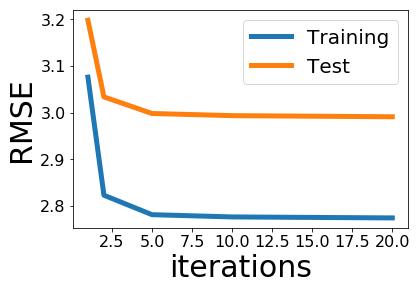

In [32]:
%timeit
iter_array = [1, 2, 5, 10, 20]

reg = 0.01 # regularization level
n_factors = 10 # nombre de variables latentes
plot_learning_curve(iter_array, calculate_learning_curve_als(matrice_train, matrice_test, iter_array,  user_reg=reg, movie_reg=reg, n_factors=n_factors))
#40 min
#scores moyens : k=5 best, score test 3, score train 2.8